## Import Libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [65]:
stock_intc = pd.read_csv('../../../Dataset/INTC.csv')
stock_intc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [66]:
# Convert the 'Date' column to datetime format
stock_intc['Date'] = pd.to_datetime(stock_intc['Date'])

# Set the 'Date' column as the index value
stock_intc = stock_intc.set_index(pd.DatetimeIndex(stock_intc['Date'].values))

# Create new datafram with Date and Close
df_intc = pd.DataFrame(stock_intc, columns=['Close'])

### Data normalization

In [67]:
scaler = MinMaxScaler(feature_range=(0,1))
df_intc = scaler.fit_transform(np.array(df_intc).reshape(-1,1))

### Data splitting

In [68]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(df_intc) * 0.6)
val_size = int(len(df_intc) * 0.2)
test_size = len(df_intc) - train_size - val_size

In [69]:
# Get Data 
train_data = df_intc[:train_size]
val_data = df_intc[train_size:train_size+val_size]
test_data = df_intc[train_size+val_size:]

In [70]:
# Create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [71]:
# Reshape into X=t,t+1,t+2..t+100 and Y=t+100
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)

# Get lost data for val
val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data_extended, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [72]:
# Make input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

## Model training and testing

In [73]:
# Define model
    # Pack the sequence of the inner layers
model = Sequential()
    # LSTM with 64 units with reture_sequences = true => preidct along to the series
model.add(LSTM(64, return_sequences=True, input_shape = (time_step, 1)))
    # LSTM with 64 units with reture_sequences = false => get the last predict
model.add(LSTM(64, return_sequences=False, input_shape = (time_step, 1)))
    # Dropout: Avoid remembering too much information => disable part of the previous data
model.add(Dropout(0.2))
    # 1 Dense layer (dense): 1 unit provides predictive value, using activiation function: relu
model.add(Dense(1,activation='relu'))
    # Compile model with loss function: MST, optimize: adam 
model.compile(loss='mean_squared_error', optimizer='adam')

In [74]:
# Using earlystopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [75]:
# Training LSTM model
model.fit(X_train, y_train, validation_data=(X_val, yval), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
9/9 [==============================] - 25s 1s/step - loss: 0.1677 - val_loss: 0.0386
Epoch 2/100
9/9 [==============================] - 3s 327ms/step - loss: 0.0204 - val_loss: 0.0058
Epoch 3/100
9/9 [==============================] - 3s 382ms/step - loss: 0.0151 - val_loss: 0.0164
Epoch 4/100
9/9 [==============================] - 3s 323ms/step - loss: 0.0105 - val_loss: 0.0033
Epoch 5/100
9/9 [==============================] - 2s 279ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 6/100
9/9 [==============================] - 3s 383ms/step - loss: 0.0103 - val_loss: 0.0042
Epoch 7/100
9/9 [==============================] - 3s 299ms/step - loss: 0.0096 - val_loss: 0.0060
Epoch 8/100
9/9 [==============================] - 4s 395ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 9/100
9/9 [==============================] - 3s 395ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 10/100
9/9 [==============================] - 3s 331ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 11/10

### Testing process

In [76]:
# Predict
    # Test
y_pred = model.predict(X_test)
    # Val
y_pred_val = model.predict(X_val)

7/7 [==============================] - 1s 85ms/step


### Evaluate model

In [77]:
# Evaluate the accuracy of validate
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, yval)

print(f"MAPE on Validate dataset: ", val_mape)
print(f"RMSE on Validate dataset: ", val_rmse)
print(f"MSLE on Validate dataset: ", val_msle)

MAPE on Validate dataset:  0.07873852854348055
RMSE on Validate dataset:  0.053192641260054574
MSLE on Validate dataset:  0.0012633830430800635


In [78]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.4101139153271741
RMSE on Test dataset:  0.07163835014291055
MSLE on Test dataset:  0.0039869464991403375


## Predicting the next 30 days

### Preparing the prediction data

In [79]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [80]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.20269808173179626], [0.21076084673404694], [0.22003500163555145], [0.23009184002876282], [0.24062606692314148], [0.25142350792884827], [0.2623366415500641], [0.2732655107975006], [0.2841440737247467], [0.29492974281311035], [0.3055958151817322], [0.31612637639045715], [0.3265131115913391], [0.33675187826156616], [0.34684228897094727], [0.3567854166030884], [0.36658379435539246], [0.3762407600879669], [0.38575997948646545], [0.3951452076435089], [0.4044002294540405], [0.4135288596153259], [0.4225345253944397], [0.43142062425613403], [0.4401896297931671], [0.4488445818424225], [0.4573875367641449], [0.4658202826976776], [0.47414475679397583], [0.48236173391342163]]


### Preparing the forecast date index

In [81]:
# Get the last date from the current index
last_date = stock_intc.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [82]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [83]:
# Convert to normal values
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Visualization

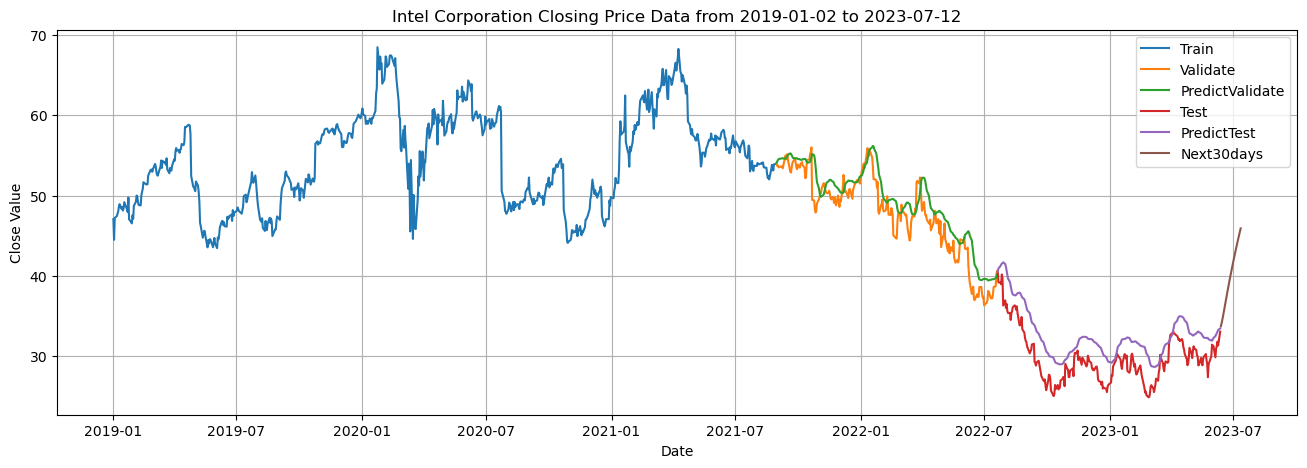

In [84]:
plt.figure(figsize=(16,5))

plt.plot(stock_intc.index[:train_size], train_data)

plt.plot(stock_intc.index[train_size:train_size + val_size],val_data)

plt.plot(stock_intc.index[train_size:train_size + val_size],y_pred_val)

plt.plot(stock_intc.index[train_size + val_size: ], test_data)

plt.plot(stock_intc.index[train_size + val_size: ],(y_pred))

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Intel Corporation Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate', 'PredictValidate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/LSTM_622_INTC.png')
plt.show()